In [2]:
import cython
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pymc3 as pm
import theano
import theano.tensor as tt

import tensorflow as tf

from pymc3.distributions import continuous
from pymc3.distributions import distribution

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
def pad(array, epsilon=1e-4):
    output = []
    
    for x in array:
        if x == 0:
            output.append(epsilon)
        elif x == 1:
            output.append(1 - epsilon)
        else:
            output.append(x)
            
    return output


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train/255
x_test  = x_test/255

In [4]:
image = x_train[12]
image = pad(np.concatenate(image))

In [5]:
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location

    Note that tau = 1/sigma^2
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)

        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))
    
def plot(image, figsize=(16, 7)):
    
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap="Greys")

In [6]:
adj = []
position_matrix = np.linspace(0, 28*28 - 1, num=28*28).astype(np.int64).reshape(28, 28)
count = 0

for i, row in enumerate(position_matrix):
    for j, col in enumerate(position_matrix[i]):
        assert position_matrix[i][j] == col
        
        temp = []

        # change these loops if we do not want to
        # include diagonal elements in adj matrix
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                if ((i + delta_i) // 28 == 0) and ((j + delta_j) // 28 == 0):    
                    temp.append(position_matrix[i + delta_i][j + delta_j])
        

        temp.remove(col)
        temp.sort()
        adj.append(temp)
        
weights = [list(np.ones_like(adj_elems).astype(np.int64)) for adj_elems in adj]

# below is taken from the pymc3 CAR tutorial website
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype="int32")
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

In [26]:
NUM_IMAGES = 20

In [29]:
uniform_tolerance = 1e-3

with pm.Model() as model:
    
    intercept = {}
    tau = {}
    mu_phi = {}
    phi = {}
    Y = {}
    
    for digit in range(10):
        intercept[digit] = pm.Normal(f"intercept_{digit}", mu=0., tau=1e-2)
        tau[digit]    = pm.Gamma(f"tau_c_{digit}", alpha=1.0, beta=1.0)
        mu_phi[digit] = CAR2(f"mu_phi_{digit}", w=wmat2, a=amat2, tau=tau[digit], shape=N)
        phi[digit]    = pm.Deterministic(f"phi_{digit}", mu_phi[digit]-tt.mean(mu_phi[digit])) # zero-center phi

        
    p = pm.Dirichlet("p", a=np.ones(10))
    obs = pm.Mixture("obs", 
                     w=p, 
                     comp_dists=[pm.LogitNormal.dist(mu=intercept[digit]+mu_phi[digit]) for digit in range(10)], 
                     observed=x_train[:NUM_IMAGES].reshape(NUM_IMAGES, -1))
    print("model looks okay?")
    trace = pm.sample(draws=2000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


model looks okay?

You can find the C code in this temporary file: /tmp/theano_compilation_error_6318vq7z


Exception: ('Compilation failed (return status=-2): /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp: In member function ‘int {anonymous}::__struct_compiled_op_m942ee47a72b306dce5bd5ac78df811d8a57b0f502a38304ab303d4cfd9da86c0::run()’:. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:490:27: warning: narrowing conversion of ‘V1_n0’ from ‘npy_intp’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   490 |     int init_totals[3] = {V1_n0, V1_n1, V1_n2};.       |                           ^~~~~. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:490:34: warning: narrowing conversion of ‘V1_n1’ from ‘npy_intp’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   490 |     int init_totals[3] = {V1_n0, V1_n1, V1_n2};.       |                                  ^~~~~. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:490:41: warning: narrowing conversion of ‘V1_n2’ from ‘npy_intp’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   490 |     int init_totals[3] = {V1_n0, V1_n1, V1_n2};.       |                                         ^~~~~. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:507:1: warning: narrowing conversion of ‘V1_stride0’ from ‘ssize_t’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   507 | V1_stride0, V1_stride1, V1_stride2.       | ^~~~~~~~~~. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:507:13: warning: narrowing conversion of ‘V1_stride1’ from ‘ssize_t’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   507 | V1_stride0, V1_stride1, V1_stride2.       |             ^~~~~~~~~~. /home/larry/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.3-64/tmpl4h9s_ws/mod.cpp:507:25: warning: narrowing conversion of ‘V1_stride2’ from ‘ssize_t’ {aka ‘long int’} to ‘int’ [-Wnarrowing].   507 | V1_stride0, V1_stride1, V1_stride2.       |                         ^~~~~~~~~~. ', '[Elemwise{second}(<TensorType(bool, (True, True, True))>, <TensorType(bool, (True, True, True))>)]')

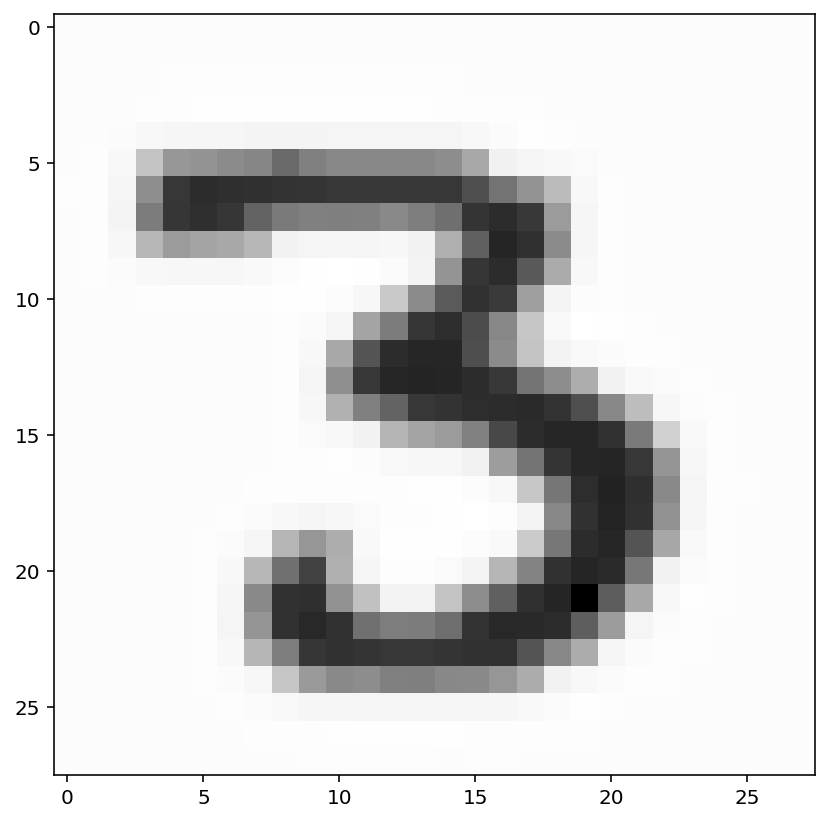

In [18]:
plot(trace.get_values("mu_phi").mean(axis=0).reshape(28, 28))

In [34]:
x_train = np.array([pad(image) for image in x_train.reshape(x_train.shape[0], -1)])